# Detecting and Mitigating Bias Using AI Fairness 360
## Using "Adversarial Debiasing"
---

## Introduction

 Machine learning models are increasingly used to inform high stakes decisions about people. Although machine learning, by its very nature, is always a form of statistical discrimination, the discrimination becomes objectionable when it places certain privileged groups at systematic advantage and certain unprivileged groups at systematic disadvantage. Biases in training data, due to either prejudice in labels or under-/over-sampling, yields models with unwanted bias.

The AI Fairness 360 Python package includes a comprehensive set of metrics for datasets and models to test for biases, explanations for these metrics, and algorithms to mitigate bias in datasets and models. The AI Fairness 360 interactive demo provides a gentle introduction to the concepts and capabilities. The tutorials and other notebooks offer a deeper, data scientist-oriented introduction. The complete API is also available. 

For more information see links below:

- AIF360 Demo: https://aif360.mybluemix.net
- AIF360 GitHub: https://github.com/IBM/AIF360
- AIF360 API Docs: https://aif360.readthedocs.io/en/latest/

## Tutorial Objective

In this notebook you will utilize AIF360 to detect and mitigate bias on the Compas dataset which is used to assess the likelihood that a criminal defendant will re-offend. 

Upon completing this lab you will learn how to:

- Load datasets from the toolkit package
- Check the dataset for bias
- Mitigate existing bias in using Adversarial Debiasing technique
- Train on both original and corrected dataset and compare results

## Environment
This tutorial uses a Jupyter Notebook, an open-source web applicaiton that allows you to create and share documents that contain instructions as well as live code.

The Jupyter Notebooks we are using today is based on a Watson Studio environment, a set of open source packages that provide us with a standardized data analysis tools. At multiple points during the demo, we will important additional tools we need for specific steps:

E.g. `import pandas as pd` -> to import the "pandas" tool for data manipulation.

E.g. `!pip install wget` -> to install a tool "wget" to download data from external webpages.

Watson Studio also contains a set of functionality that allows a user to pre-define a set of environments down to the package version level as well as define the hardware configurations available to certain users, allowing teams to easily standardize toolsets and resources. If needed, we can also connect our notebooks to GPUs, Apache Spark, and external clusters for higher performance.

## Instructions

Please follow the steps below:

## 1- Required Libraries and Functions
Here we load the AI Fairness 360 library.

In [14]:
!pip install aif360

In [15]:
%matplotlib inline
# Load all necessary packages
import sys
import pandas as pd

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

from IPython.display import Markdown, display

# to plot graphs
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import tensorflow as tf

from colorama import Fore


## 2- Importing COMPAS Dataset

Across the nation, judges, probation and parole officers are increasingly using algorithms to assess a criminal defendant’s likelihood of becoming a recidivist – a term used to describe criminals who re-offend. One of the tools used is called COMPAS (which stands for Correctional Offender Management Profiling for Alternative Sanctions) and the dataset it uses is the Compas dataset which you will be working with in this lab. By analyzing this datset, it was found that African-American defendants were far more likely than Caucasian defendants to be incorrectly judged to be at a higher risk of recidivism, while Caucasian defendants were more likely than African-American defendants to be incorrectly flagged as low risk, therefore, this dataset is biased.

To perform bias detection and mitigation using AIF360, the toolkit needs to be tailored to the particular bias of interest. More specifically, it needs to know the attribute or attributes to track, called "protected attributes", that are of interest: in this dataset, "race" and "sex" are protected attributes.

For purpose of this lab, we choose the "Race" attribute.

In the code below, `dataset_orig` loads the COMPAS dataset. We then set numerical values for race for privileged and unprivileges groups.

In [16]:
# Get the dataset and split into train and test
dataset_orig = load_preproc_data_compas()

privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

Below, we split our dataset into a testing set and a training set. A training set is used to build our machine learning model. The test data set is used to assess the performance of our model.

In [13]:
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape (Number of Rows , Number of Columns)"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)


#### Training Dataset shape (Number of Rows , Number of Columns)

(3694, 10)


#### Protected attribute names

['sex', 'race']


## 2.1. Data Visualization

Before we begin building our models, we want to understand the shape of our data. In this step, you will see a visual analysis on the Compas Dataset. This cell plots out the risk score for two racial groups in focus: "African-American" and "White-Caucasian". These charts show that scores for White-Caucasian defendants were skewed toward lower-risk categories. Scores for African American defendants were not. This leads to the belief that African-American defendants are a higher risk and may re-offend more frequently.

### 2.1.1 Import Compas data set as a Pandas Dataframe

`import wget` pulls in the wget library to load data from the github link.

`import pandas as pd` pulls in the Pandas library for data manipulation and analysis. 

`!rm compas-scores-two-years.csv` removes data that we may have pulled in on a previous run of this notebook.

In [4]:
!pip install wget
import wget 
import pandas as pd
link_to_data = 'https://raw.githubusercontent.com/bleonardb3/Think2020/master/Lab-1/data/compas-scores-two-years.csv'

# make sure no duplicates
!rm  compas-scores-two-years.csv

data_set = wget.download(link_to_data)

print(data_set)

compas_data_df = pd.read_csv(data_set, sep=',')


  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
rm: cannot remove ‘compas-scores-two-years.csv’: No such file or directory
compas-scores-two-years.csv


### 2.1.2 Visualize Compas Data 

The code below uses plt to stand in for Matplotlib, a general purpose "plotting" library to create the graphs below. The series of lines below set graph parameters and then displays the graph.

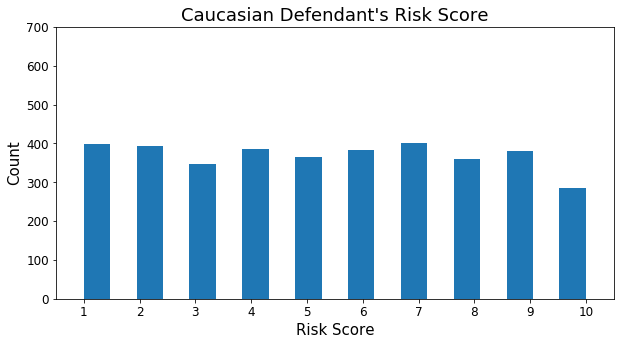

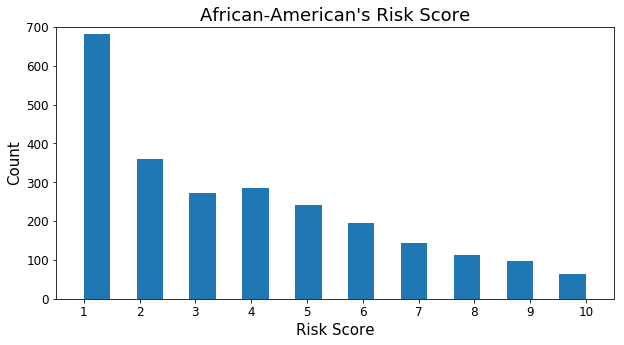

In [5]:
af_data = compas_data_df.loc[compas_data_df['race'] == "African-American"]
wc_data = compas_data_df.loc[compas_data_df['race'] == "Caucasian"]

af_data.hist(column=['decile_score.1'], bins=19, figsize=(10,5), xlabelsize=12, ylabelsize=12, grid = False)
plt.xlabel("Risk Score", fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.ylim([0, 700])
plt.xlim([0.5,10.5])
plt.xticks(np.arange(1, 11, step=1))
plt.title("Caucasian Defendant's Risk Score", fontsize = 18)

wc_data.hist(column=['decile_score.1'], bins=19, figsize=(10,5), xlabelsize=12, ylabelsize=12, grid = False)
plt.xlabel("Risk Score", fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.ylim([0, 700])
plt.xlim([0.5,10.5])
plt.xticks(np.arange(1, 11, step=1))
plt.title("African-American's Risk Score", fontsize = 18)

plt.show()

## 3. Checking Original Dataset for Bias

Now that we've identified the protected attribute and defined privileged and unprivileged values, we can use AIF360 to detect bias in the dataset. One simple test is to compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter. A negative value indicates less favorable outcomes for the unprivileged groups. Within AIF360, this is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class. The code below performs mean difference calculation and displays the output on both train and test sets.

In [6]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())
metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Original training dataset

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.134007
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.128236


The negative output indicates less favorable outcomes for the unprivileged group.

### 3.1. Check for bias in dataset after scaling the data

Scaling is a common data preparation technique to ensure that large numerical values do not overwhelm a smaller ones. In the code below, we test scaling our inputs to see if the differences between privileged and unprivileged group outcomes changes. Though we do not find a change in outcomes, this is a good practice to consider when pre-processing data for certain types of machine learning models.

In [7]:
min_max_scaler = MaxAbsScaler()
dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
display(Markdown("Note that scaling the dataset did not have an effect on the result."))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())



#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Note that scaling the dataset did not have an effect on the result.

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.134007
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.128236


## 4. Train on Original Dataset

Here we train a Logistic Regression model on the original training data and obtain the accuracy using TensorFlow.

TensorFlow is an extremely popular machine learning library. See: https://www.tensorflow.org/

Obtaining the original accuracy here is necessary because we need to compare it to the accuracy obtained after bias mitigation - to make sure our model will continue to perform well.

`sess = tf.Session()` sets TensorFlow to a session. The remaining code defines the parameters for our model and then trains it.

In [8]:
sess = tf.Session()
plain_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)
plain_model.fit(dataset_orig_train)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
epoch 0; iter: 0; batch classifier loss: 0.699173
epoch 1; iter: 0; batch classifier loss: 0.628936
epoch 2; iter: 0; batch classifier loss: 0.638225
epoch 3; iter: 0; batch classifier loss: 0.626591
epoch 4; iter: 0; batch classifier loss: 0.586548
epoch 5; iter: 0; batch classifier loss: 0.646828
epoch 6; iter: 0; batch classifier loss: 0.624506
epoch 7; iter: 0; batch classifier loss: 0.657383
epoch 8; iter: 0; batch classifier loss: 0.639813
epoch 9; iter: 0; batch classifier loss: 0.617464
epoch 10; iter: 0; batch classifier loss: 0.601837
epoch 11; iter: 0; batch c

## ** Classification Metric References **

Classification metric refers to a quantification of unwanted bias in models. 

Moving forward with the lab, you will compute and compare several classification metrics as below. Please refer to this cell when comparing metric values. Each metric value should fall within a certain range for their corresponding metric. 

- #### Disparate Impact
Computed as the ratio of rate of favorable outcome for the unprivileged group to that of the privileged group. The ideal value of this metric is 1.0 A value < 1 implies higher benefit for the privileged group and a value >1 implies a higher benefit for the unprivileged group. Fairness for this metric is between 0.8 and 1.2

- #### Equal Opportunity Difference
This metric is computed as the difference of true positive rates between the unprivileged and the privileged groups. The true positive rate is the ratio of true positives to the total number of actual positives for a given group. The ideal value is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. Fairness for this metric is between -0.1 and 0.1

- #### Average Odds Difference
Computed as average difference of false positive rate (false positives / negatives) and true positive rate (true positives / positives) between unprivileged and privileged groups. The ideal value of this metric is 0. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. Fairness for this metric is between -0.1 and 0.1

### 4.1. Classification Metrics of Plain Model - not Debiased

The code below calculates and displays the results of the plain, non-debiased model for the classification metrics above (disparate impact, equal opportunity difference, and average odds difference).

In [9]:
# Apply the plain model to train and test data
dataset_nodebiasing_train = plain_model.predict(dataset_orig_train)
dataset_nodebiasing_test = plain_model.predict(dataset_orig_test)

# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(Fore.RESET + "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(Fore.RESET + "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
classified_metric_nodebiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)

print(Fore.RESET + "Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
if 0.8 < classified_metric_nodebiasing_test.disparate_impact() < 1.2:
    print(Fore.RESET + "Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
else:
    print(Fore.RESET + "Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact() , Fore.RED + "      *** Bias Detected")

if  -0.1 < classified_metric_nodebiasing_test.equal_opportunity_difference() < 0.1:
    print(Fore.RESET + "Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
else:
    print(Fore.RESET + "Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference(), Fore.RED + "      *** Bias Detected")

if  -0.1 < classified_metric_nodebiasing_test.average_odds_difference() < 0.1:
    print(Fore.RESET + "Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
else:
    print(Fore.RESET + "Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference(), Fore.RED + "      *** Bias Detected")

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.216662
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.231147


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.671717
Test set: Balanced classification accuracy = 0.667847
Test set: Disparate impact = 0.677624       *** Bias Detected
Test set: Equal opportunity difference = -0.161866       *** Bias Detected
Test set: Average odds difference = -0.194818       *** Bias Detected


Note the results. The items in red are outside the bounds of a fair model signalling that the original model is biased and that we will need to apply bias mitigation.

## 5. Apply Adversarial Debiasing

Adversarial debiasing is an in-processing technique that learns a classifier to maximize prediction accuracy and simultaneously reduce an adversary's ability to determine the protected attribute from the predictions [1]. This approach leads to a fair classifier as the predictions cannot carry any group discrimination information that the adversary can exploit.

In this cell, you will create a Debiased Model using Adversarial Debiasing and train it on the dataset.

The code below creates a new TensorFlow session and builds a machine learning model on the same data as ealier, this time with debiasing (note the `debias=True` line).

In [10]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)
debiased_model.fit(dataset_orig_train)

epoch 0; iter: 0; batch classifier loss: 0.695619; batch adversarial loss: 0.672732
epoch 1; iter: 0; batch classifier loss: 0.647462; batch adversarial loss: 0.667515
epoch 2; iter: 0; batch classifier loss: 0.657833; batch adversarial loss: 0.688143
epoch 3; iter: 0; batch classifier loss: 0.619532; batch adversarial loss: 0.673071
epoch 4; iter: 0; batch classifier loss: 0.594560; batch adversarial loss: 0.716215
epoch 5; iter: 0; batch classifier loss: 0.629858; batch adversarial loss: 0.654015
epoch 6; iter: 0; batch classifier loss: 0.619000; batch adversarial loss: 0.662577
epoch 7; iter: 0; batch classifier loss: 0.631707; batch adversarial loss: 0.641666
epoch 8; iter: 0; batch classifier loss: 0.605773; batch adversarial loss: 0.695586
epoch 9; iter: 0; batch classifier loss: 0.617582; batch adversarial loss: 0.695679
epoch 10; iter: 0; batch classifier loss: 0.633811; batch adversarial loss: 0.672513
epoch 11; iter: 0; batch classifier loss: 0.617589; batch adversarial loss:

### 5.1. Comparing Results

This step calculates and prints out the result of the bias mitigation process. 

In [11]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(dataset_orig_train)
dataset_debiasing_test = debiased_model.predict(dataset_orig_test)

# Metrics for the dataset from plain model (without debiasing)
display(Markdown("#### Plain model - without debiasing - dataset metrics"))
print(Fore.RESET + "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())
print(Fore.RESET + "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model - with debiasing - dataset metrics"))
metric_dataset_debiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(Fore.RESET + "Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_train.mean_difference())

metric_dataset_debiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print(Fore.RESET + "Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_debiasing_test.mean_difference())

display(Markdown("#### Plain model - without debiasing - classification metrics"))
print(Fore.RESET + "Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print(Fore.RESET + "Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)

if 0.8 < classified_metric_nodebiasing_test.disparate_impact() < 1.2:
    print(Fore.RESET + "Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
else:
    print(Fore.RED + "Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())

if  -0.1 < classified_metric_nodebiasing_test.equal_opportunity_difference() < 0.1:
    print(Fore.RESET + "Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
else:
    print(Fore.RED + "Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())

if  -0.1 < classified_metric_nodebiasing_test.average_odds_difference() < 0.1:
    print(Fore.RESET + "Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
else:
    print(Fore.RED + "Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())

# print(Fore.RESET + "Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())


display(Markdown("#### Model - with debiasing - classification metrics"))
classified_metric_debiasing_test = ClassificationMetric(dataset_orig_test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_debiasing_test.accuracy())
TPR = classified_metric_debiasing_test.true_positive_rate()
TNR = classified_metric_debiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print(Fore.RESET + "Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print(Fore.RESET + "Test set: Disparate impact = %f" % classified_metric_debiasing_test.disparate_impact(), Fore.GREEN + "    *** Fairness Achieved ***")
print(Fore.RESET + "Test set: Equal opportunity difference = %f" % classified_metric_debiasing_test.equal_opportunity_difference(), Fore.GREEN + "    *** Fairness Achieved ***")
print(Fore.RESET + "Test set: Average odds difference = %f" % classified_metric_debiasing_test.average_odds_difference(), Fore.GREEN + "    *** Fairness Achieved ***")

#### Plain model - without debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.216662
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.231147


#### Model - with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.011198
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.000814


#### Plain model - without debiasing - classification metrics

Test set: Classification accuracy = 0.671717
Test set: Balanced classification accuracy = 0.667847
Test set: Disparate impact = 0.677624
Test set: Equal opportunity difference = -0.161866
Test set: Average odds difference = -0.194818


#### Model - with debiasing - classification metrics

Test set: Classification accuracy = 0.654040
Test set: Balanced classification accuracy = 0.654431
Test set: Disparate impact = 0.998380     *** Fairness Achieved ***
Test set: Equal opportunity difference = 0.075718     *** Fairness Achieved ***
Test set: Average odds difference = 0.034825     *** Fairness Achieved ***


The lines printed in red show bias in the original model and the lines with green writing "Fairness Achieved" mean that the bias mitigation algorithm was successfuly applied fairness to the model and the classification metric results have moved closer to the aceptable range. In a best case scenario they will fall in the desired range. This means fairness is achieved.

### 5.2. Visualizing Results

Let's visualize the results as well. The code below takes our calculations and displays each charts comparing the original results to the results with bias mitigation applied.

We first calculate the original and mitigated results using each fairness metric (disparate impact, opportunity difference, and average odds difference):

Example for disparate impact:

`orig_DI = classified_metric_nodebiasing_test.disparate_impact()`

`mitigated_DI = classified_metric_debiasing_test.disparate_impact()`

We then use Matplotlib, assigned to `plt` to chart our results.

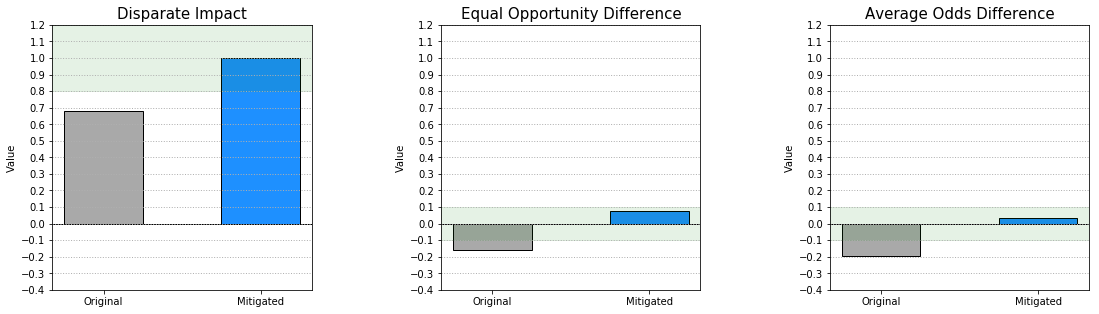

In [12]:
orig_DI = classified_metric_nodebiasing_test.disparate_impact()
mitigated_DI = classified_metric_debiasing_test.disparate_impact()

orig_EOD = classified_metric_nodebiasing_test.equal_opportunity_difference()
mitigated_EOD = classified_metric_debiasing_test.equal_opportunity_difference()

orig_AOD = classified_metric_nodebiasing_test.average_odds_difference()
mitigated_AOD = classified_metric_debiasing_test.average_odds_difference()

N = 2
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence
xtype = ('Original', 'Mitigated')
ind = np.arange(len(xtype))

# Disparate Impact

values_DI = [orig_DI, mitigated_DI]
# print("values_DI =  ", values_DI, end='\t')

plt.subplot(1,3,1)
p1_DI = plt.bar(ind, values_DI, width = width, color=['darkgray', 'dodgerblue'], edgecolor='black') #, yerr=menStd)
plt.xticks(ind, xtype)
plt.grid(b=None, which='major', axis='y', linestyle=':', linewidth=1)
plt.ylabel('Value')
plt.title('Disparate Impact', fontsize=15)
plt.ylim([-0.4, 1.2])
plt.yticks(np.arange(-0.4, 1.3, 0.1)) 
plt.axhspan(ymin = 0.8, ymax = 1.2, color='green', alpha=0.1)
plt.axhspan(ymin = 0, ymax = 0, edgecolor='black', alpha=1)
# plt.legend(xtype)



# --------------------------------------------------------------------------------------------------------
# Equal Opprortunity Difference

values_EOD = [orig_EOD, mitigated_EOD]
# print("values_EOD = ", values_EOD, end='\t')

plt.subplot(1,3,2)
p1_EOD = plt.bar(ind, values_EOD, width = width, color=['darkgray', 'dodgerblue'], edgecolor='black')
plt.xticks(ind, xtype)
plt.grid(b=None, which='major', axis='y', linestyle=':', linewidth=1)
plt.ylabel('Value')
plt.title('Equal Opportunity Difference', fontsize=15)
plt.ylim([-0.4, 1.2])
plt.yticks(np.arange(-0.4, 1.3, 0.1))
plt.axhspan(ymin = -0.1, ymax = 0.1, color='green', alpha=0.1)
plt.axhspan(ymin = 0, ymax = 0, edgecolor='black', alpha=1)


# --------------------------------------------------------------------------------------------------------
# Average odds difference

values_AOD = [orig_AOD, mitigated_AOD]
# print("values_AOD = ", values_AOD)

ax = plt.subplot(1,3,3)
p1_AOD = plt.bar(ind, values_AOD, width = width, color=['darkgray', 'dodgerblue'], edgecolor='black') #, yerr=menStd)
plt.xticks(ind, xtype)
plt.grid(b=None, which='major', axis='y', linestyle=':', linewidth=1)
plt.ylabel('Value')
plt.title('Average Odds Difference', fontsize=15)
plt.ylim(-0.4, 1.2)
plt.yticks(np.arange(-0.4, 1.3, 0.1))
plt.axhspan(ymin = -0.1, ymax = 0.1, color='Green', alpha=0.1)
plt.axhspan(ymin = 0, ymax = 0, edgecolor='black', alpha=1)
plt.subplots_adjust(top=1, bottom=0.08, left=0.10, right=2.5, hspace=0.5, wspace=0.5)
plt.show()

What does the numbers above mean? This cell demostrates the result of the bias mitigation on graphs using the difference fairness measures. 

The blue bar is the mitigated result

The gray bar is the original (base case).

Notice that the blue bar (with bias mitigation) is closer to the desired range and in the base case scenario, it falls in the desired range. This means that fairness is achieved.

References:

[1] B. H. Zhang, B. Lemoine, and M. Mitchell, "Mitigating UnwantedBiases with Adversarial Learning," 
AAAI/ACM Conference on Artificial Intelligence, Ethics, and Society, 2018.